In [65]:
import numpy as np
from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend
from qilisdk.functionals import TimeEvolution
import matplotlib.pyplot as plt

Our time-dependent Hamiltonian is


$$
H(s) = s \begin{pmatrix} 0        & \epsilon \\ 
                         \epsilon & 0 
         \end{pmatrix}

         + 

         (0.5 -s) \begin{pmatrix} \alpha   & \epsilon \\ 
                                  \epsilon & -\alpha 
                  \end{pmatrix}
$$

With $s$ going from 0 to 1. This way, the first term is zero at the start of the annealing, giving a gap of $\sqrt{\alpha^2 + \epsilon^2}$, at the middle of the annealing the second term is zero, so we have a minimum gap of $2\epsilon$. And at the end of the annealing, the terms combine to give the same Hamiltonian as in the begining, with the sign of $\alpha$ inverted, that is we recover the same gap as the begining

Below there is an example of the linear schedule


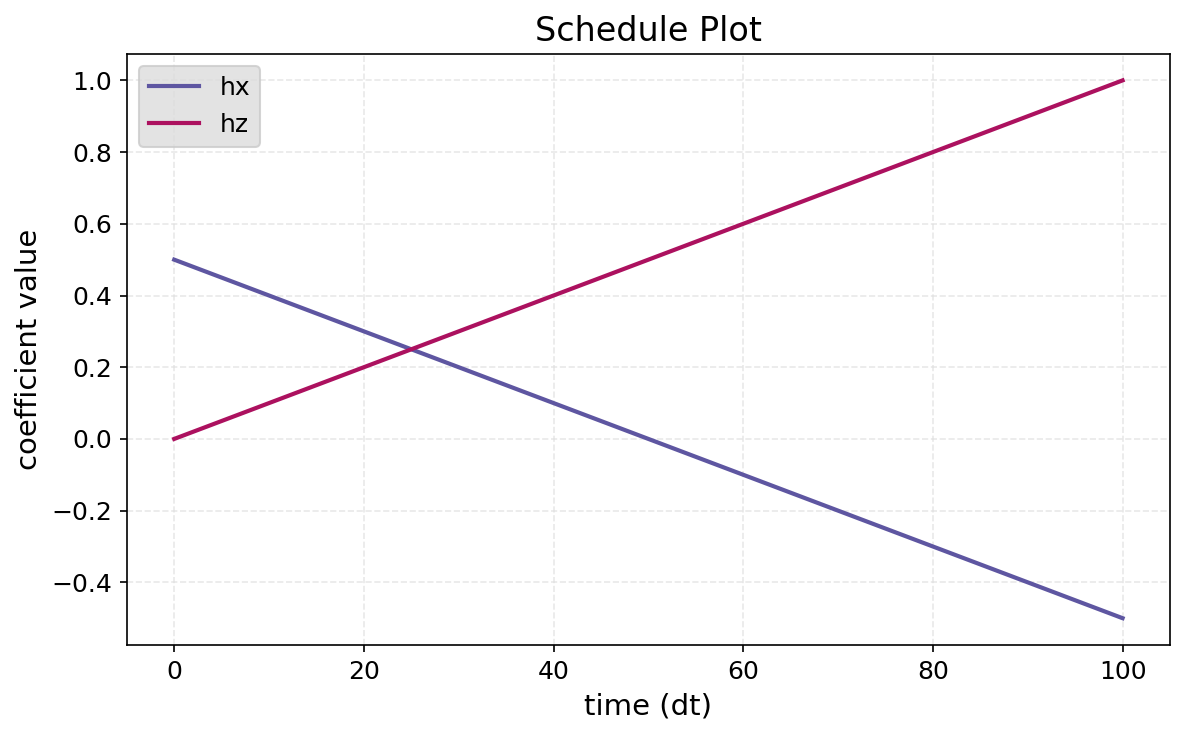

In [66]:
#System parameters
nqubits = 1
alpha = np.sqrt(8.)
epsilon = 1.

#Hamiltonians
Hx = alpha*X(0) + epsilon*Z(0)
Hz = epsilon*Z(0)

#Scheduler parameters
T = 100.0
dt = 0.1

# Build a time‑dependent schedule
schedule = Schedule(
    hamiltonians={"hx": Hx, "hz": Hz},
    coefficients={
        "hx": {(0.0, T): lambda t: 0.5 - t / T},
        "hz": {(0.0, T): lambda t: t / T},
    },
    dt=dt,
)

# draw the schedule
schedule.draw()

Next, we define the hamiltonian and run a test to show the spectrum as a function of time

In [67]:
def H(a, e, t):
    sx = np.array([[1,0],[0,-1]])
    sz = np.array([[0,1],[1,0]])
    Hx = a*sx + epsilon*sz
    Hz = epsilon*sz
    H = t*Hz + (0.5 - t)*Hx
    return H

In [68]:
alpha = np.sqrt(15.5)
epsilon = 0.5
t_list = np.linspace(0, 1, 101)
g, e = [], []

for t in t_list:
    Ham = H(alpha, epsilon, t)
    eigvals, eigvecs = np.linalg.eigh(Ham)
    g.append(eigvals[0])
    e.append(eigvals[1])

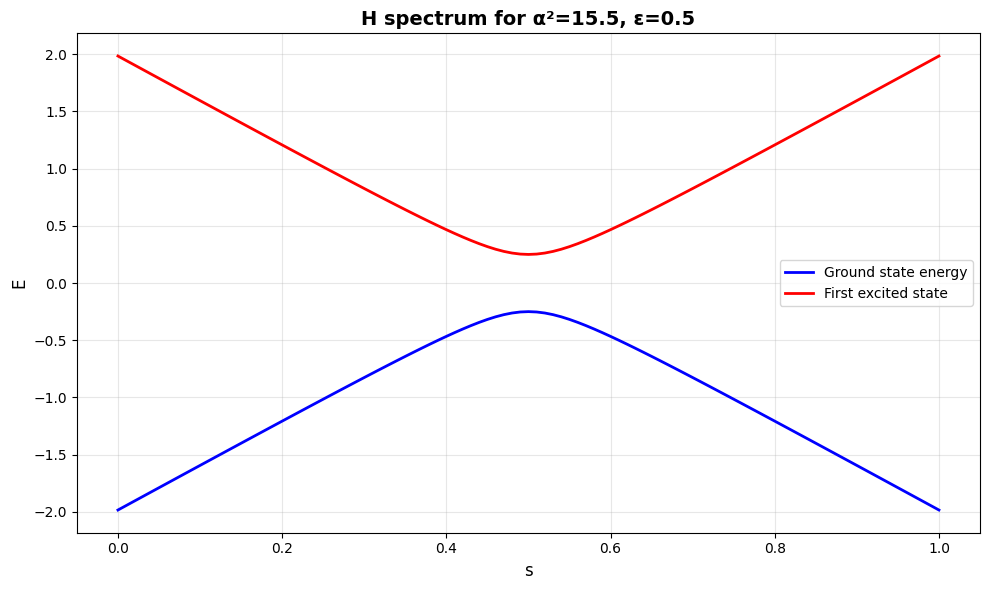

In [69]:
# Create plot
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(t_list, g, label='Ground state energy', linewidth=2, color='blue', linestyle='-')
plt.plot(t_list, e, label='First excited state', linewidth=2, color='red', linestyle='-')

# Customize
plt.title(f'H spectrum for α²={alpha**2:.1f}, ε={epsilon:.1f}', fontsize=14, fontweight='bold')
plt.xlabel('s', fontsize=12)
plt.ylabel('E', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Show
plt.tight_layout()
plt.show()

Next, we perform the annealing schedule. Here the probability of transition follows the Landau-Zener formula

$$
P = e^{-2\pi\Tau}
$$

Where $\Tau = \frac{\epsilon^2}{|\alpha|}$ (ignoring possible scalar factors). The idea is that the faster we do the annealing , the larger the probability of transition. Since we keep the schedule fixed (and by extension, the speed), we control this probability changing alpha (for a given annealing time, a high alpha will induce a larger "speed", and therefore larger transition probability)

In [70]:
def observables(state):

    # Pauli matrices
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    # Expectation values
    exp_X = state.conj().T @ X @ state
    exp_Y = state.conj().T @ Y @ state
    exp_Z = state.conj().T @ Z @ state

    return exp_X, exp_Y, exp_Z



#

In [71]:

def annealing(epsilon, alpha, T, dt):
    #Hamiltonians
    Hx = alpha*X(0) + epsilon*Z(0)
    Hz = epsilon*Z(0)


    # Build a time‑dependent schedule
    schedule = Schedule(
        hamiltonians={"hx": Hx, "hz": Hz},
        coefficients={
            "hx": {(0.0, T): lambda t: 0.5 - t / T},
            "hz": {(0.0, T): lambda t: t / T},
        },
        dt=dt,
    )
    #Prepare initial state (ground state at s=0)

    Ham = H(alpha, epsilon, 0)
    eigvals, eigvecs = np.linalg.eigh(Ham)
    g = eigvecs[0]


    # Prepare an equal superposition initial state
    initial_state = tensor_prod([(g[0]*ket(0) - g[1]*ket(1)).unit() for _ in range(nqubits)]).unit()

    ox, oy, oz = observables(g)

    # Create the TimeEvolution functional
    time_evolution = TimeEvolution(
        schedule=schedule,
        initial_state=initial_state,
        observables=[Z(0), X(0), Y(0)],
        nshots=100,
        store_intermediate_results=False,
    )

    # Execute on Qutip backend and inspect results
    backend = QutipBackend()
    results = backend.execute(time_evolution)

    return ox, oy, oz, results

In [79]:
alpha = np.linspace(1, 15, 101)
# Define total time and timestep
nqubits = 1
epsilon = 1.
T = 100.0
dt = 0.1

z_i = []
z_f = []

for a in alpha:
    ox, oy, oz, results = annealing(epsilon, a, T, dt)
    z_i.append(oz)
    z_f.append(abs(results.final_expected_values[0]))



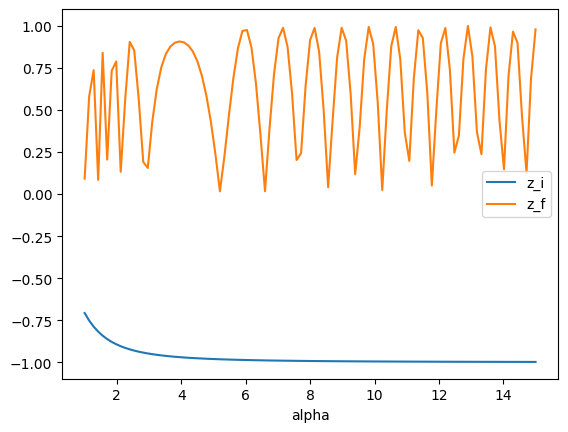

In [80]:
plt.plot(alpha, z_i, label='z_i')
plt.plot(alpha, z_f, label='z_f')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [74]:
print(r.final_expected_values[0])

-0.09163064234088936
